# Importing required Libraries

In [86]:
# Importing required Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pycrfsuite
from itertools import combinations


# Importing Data

In [87]:
data=pd.read_csv('Converted_file.csv')
data.head()

,date,location_ordinal,sku,price,discount,color_desc,style_desc,pid_desc,district_ordinal,state_ordinal,Discount,store_ID
0,20160131,1,234,8.0,2.61,BLACK,SML BLK HTHR HP BSC,SML BLK HTHR HP BSC,6,9,0.32625,961
1,20160131,1,325,8.0,2.61,GREY/BLACK,SM GRY/BK STP BS BSC,SM GRY/BK STP BS BSC,6,9,0.32625,961
2,20160131,1,454,8.0,2.60,SUGARED AL,SMLS NUDE BS BSC,SMLS NUDE BS BSC,6,9,0.32500,961
3,20160131,1,456,8.0,2.58,SUGARED AL,SMLS NUDE BS BSC,SMLS NUDE BS BSC,6,9,0.32250,961
4,20160131,1,458,8.0,2.61,SUGARED AL,SMLS NUDE BS BSC,SMLS NUDE BS BSC,6,9,0.32625,961


## Data Cleaning

In [88]:
# Changing the 7.98 price to 8
data.loc[data['price'] == 7.98, 'price'] = 8
# Removing data with negative values of discount
data=data.loc[data['discount']>=0,]
# Converting 'date' column to required date format
data['date']=pd.to_datetime((data['date']), format='%Y%m%d')

data.head()

,date,location_ordinal,sku,price,discount,color_desc,style_desc,pid_desc,district_ordinal,state_ordinal,Discount,store_ID
0,2016-01-31,1,234,8.0,2.61,BLACK,SML BLK HTHR HP BSC,SML BLK HTHR HP BSC,6,9,0.32625,961
1,2016-01-31,1,325,8.0,2.61,GREY/BLACK,SM GRY/BK STP BS BSC,SM GRY/BK STP BS BSC,6,9,0.32625,961
2,2016-01-31,1,454,8.0,2.60,SUGARED AL,SMLS NUDE BS BSC,SMLS NUDE BS BSC,6,9,0.32500,961
3,2016-01-31,1,456,8.0,2.58,SUGARED AL,SMLS NUDE BS BSC,SMLS NUDE BS BSC,6,9,0.32250,961
4,2016-01-31,1,458,8.0,2.61,SUGARED AL,SMLS NUDE BS BSC,SMLS NUDE BS BSC,6,9,0.32625,961


In [89]:
# Finding number of entries for Store-SKU combination
store_sku_counts=data.groupby(['sku', 'store_ID']).size().reset_index(name='counts')

In [90]:
store_sku_counts[store_sku_counts.counts==store_sku_counts.counts.max()]

,sku,store_ID,counts
37799,656,943,380


## Clustering Based on Style Description and Average Discount

In [91]:
cluster_mapping=pd.read_csv('cluster_mapping.csv')
data=data.merge(cluster_mapping,left_on='style_desc',right_on='style_desc')

In [92]:
# Using store number 943 and  sku 656 for our initial CRF
crf_store_sku=data[(data.sku==656) & (data.store_ID==943)]
x_values=crf_store_sku.date.reset_index(drop=1)
y_values=crf_store_sku.Discount.reset_index(drop=1)

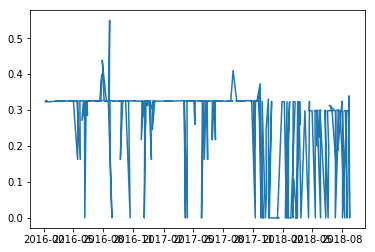

In [93]:
plt.plot(x_values,y_values)

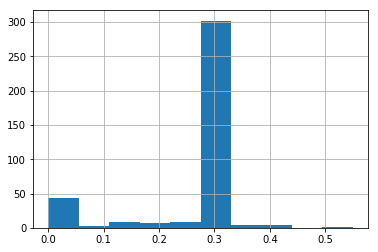

In [94]:
crf_store_sku.Discount.hist()

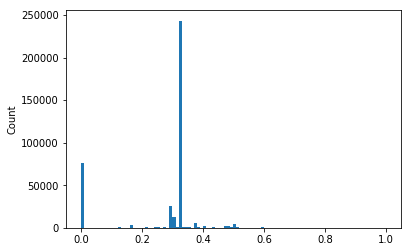

In [95]:
# Increasing the bins to check distribution
%matplotlib inline
x = data.Discount
fig=plt.hist(x, bins=100)
plt.ylabel('Count');


# Generating function to convert discount percentages to buckets

0 --> A

0-15--> B

15-30--> C

30-45--> D

45-60-->E

60-75-->F

75+ -->G

In [96]:
#  Function for Genrating buckets for discount percentage
def generate_bucket(discount):
    if(discount==0):
        return('A')
    elif(discount<0.15):
        return('B')
    elif(discount<0.30):
        return('C')
    elif(discount<0.45):
        return('D')
    elif(discount<0.60):
        return('E')
    elif(discount<0.75):
        return('F')
    else:
        return('G')
        

# Function to get data in required format for a given SKU- Store combination

In [97]:
def getData(sku,store):
        #print(sku, store)
        crf_store_sku=data[(data.sku==sku) & (data.store_ID==store)]
        crf_store_sku=crf_store_sku.reset_index(drop=1)
        
        # Generating Min date
        min_date=data.date.min()
        #Finding week_number
        week_number=[]
        for i in range(0,len(crf_store_sku.date) ):
            week_number.append(round((crf_store_sku.date[i]-min_date).days/7))
        crf_store_sku['week_number']=week_number
        
        weekly_discount=crf_store_sku.groupby(['week_number']).Discount.mean().reset_index()
        weekly_discount['imputed']=0
        
        # For missing weeks, we impute by mean discount for the CRF
        missing_week_numbers=list(set(list(range(weekly_discount.week_number.min(),weekly_discount.week_number.max())))-set(list(weekly_discount.week_number)))
        missing_week_discount=pd.DataFrame(list(zip(missing_week_numbers, [crf_store_sku.Discount.mean()]*len(missing_week_numbers) )),
                      columns=['week_number','Discount'])
        missing_week_discount['imputed']=1
        weekly_discount=weekly_discount.append(missing_week_discount).sort_values(by=['week_number']).reset_index(drop=1)
        
        #Creating Discount Bucket with our generate_bucket Function
        weekly_discount['discount_bucket']=weekly_discount.Discount.apply(generate_bucket)
        sku_cluster=list(data[data.sku==sku].Cluster)[1]
        crf_store_cluster=data[(data.sku!=sku) & (data.store_ID==store) & (data.Cluster==sku_cluster)]
        crf_store_cluster=crf_store_cluster.reset_index(drop=1)
        
        #Finding week_number
        week_number=[]
        for i in range(0,len(crf_store_cluster.date) ):
            week_number.append(round((crf_store_cluster.date[i]-min_date).days/7))
        crf_store_cluster['week_number']=week_number

        #Getting weekly discount for the given all other CRF for the same cluster except given sku
        weekly_cluster_discount=crf_store_cluster.groupby(['week_number']).Discount.mean().reset_index()
        # For missing weeks, we impute by mean discount for the CRF
        missing_week_numbers=list(set(list(range(weekly_cluster_discount.week_number.min(),weekly_cluster_discount.week_number.max())))-set(list(weekly_cluster_discount.week_number)))
        missing_week_discount=pd.DataFrame(list(zip(missing_week_numbers, [crf_store_cluster.Discount.mean()]*len(missing_week_numbers) )),
                      columns=['week_number','Discount'])
        weekly_cluster_discount=weekly_cluster_discount.append(missing_week_discount).sort_values(by=['week_number']).reset_index(drop=1)
        weekly_cluster_discount=weekly_cluster_discount[weekly_cluster_discount.week_number.isin(weekly_discount.week_number)].reset_index(drop=1)
        weekly_discount['Cluster_discount']=weekly_cluster_discount.Discount
        
        missing=[]
        # Generating random missing data to simulate missing values
        np.random.seed(0)
        for i in range(0,len(weekly_discount)):
            missing.append(np.random.choice([0,1], p=[0.5,0.5]))
        weekly_discount['missing']=missing
        
        return(weekly_discount)

 ## The above function , getData(sku,store)   performs the following tasks:
 - Filters data for the given store-sku combination
 - Aggregates discount values for a weekly level
 - Generates buckets for the weekly aggregated data based on the defination given above
 - Filters data for all Similar SKUs in the same store belonging to the same cluster except the SKU
 - Aggregates the clusters on a weekly level 
 - Imputes missing weeks with the mean discount value for the week
 - Generates Simulated missing flags
 - Return a data frame with the following information: Week Number, Discount, Imputed (1=imputed,0= not imputed), Discount Bucket, Cluster Discount, Missing (1= Missing, 0= Not missing)

# A demo for getData function

In [98]:
getData(sku=234,store=96122).head(10)

,week_number,Discount,imputed,discount_bucket,Cluster_discount,missing
0,0,0.326250,0,D,0.324643,1
1,1,0.326250,0,D,0.279583,1
2,2,0.326250,0,D,0.259500,1
3,3,0.291929,1,C,0.329779,1
4,4,0.291929,1,C,0.323092,0
5,5,0.291929,1,C,0.264188,1
6,6,0.291929,1,C,0.250385,0
7,7,0.291929,1,C,0.260000,1
8,8,0.325000,0,D,0.298333,1
9,9,0.291929,1,C,0.325625,0


# A function for feature generation for a row of data

In [99]:
def feature_gen(weekly_discount):
    X_features=[]
    for i in range(0,len(weekly_discount)):
        if(i<2):
            features={}
            features['bias']='A'
            features['cluster_discount']=weekly_discount.Cluster_discount[i]
            features['missing']=weekly_discount.missing[i]
            X_features.append(features)
        else:
            features = {}
            features['bias']='A'
            features['cluster_discount']=weekly_discount.Cluster_discount[i] 
            features['missing']=weekly_discount.missing[i]
            if(weekly_discount.missing[i]==1):
                if(weekly_discount.missing[i-1]==0):
                    features['-1 Bucket']=weekly_discount.discount_bucket[i-1]
                if(weekly_discount.missing[i-2]==0):
                    features['-2 Bucket']=weekly_discount.discount_bucket[i-2]
                if(i < len(weekly_discount)-2):
                    if (weekly_discount.missing[i+2]==0):
                        features['+2 Bucket']=weekly_discount.discount_bucket[i+2]             
                if(i < len(weekly_discount)-1):
                    if (weekly_discount.missing[i+1]==0):
                        features['+1 Bucket']=weekly_discount.discount_bucket[i+1] 
            X_features.append(features)
    return(X_features)


 ## The above function , feature_gen(data)   performs the following tasks:
 - It return a list of dictionary as features
 - Each dictionary is the feature for a week of data for one SKU-Store combinaiton

 ![feature Generation](Feature Generation.png)
 

# A demo for the feature_gen function

In [100]:
feature_gen(getData(sku=234,store=96122))[:6]

[{'bias': 'A', 'cluster_discount': 0.3246428571428571, 'missing': 1},
 {'bias': 'A', 'cluster_discount': 0.2795833333333333, 'missing': 1},
 {'bias': 'A',
  'cluster_discount': 0.25949999999999995,
  'missing': 1,
  '+2 Bucket': 'C'},
 {'bias': 'A',
  'cluster_discount': 0.3297794117647058,
  'missing': 1,
  '+1 Bucket': 'C'},
 {'bias': 'A', 'cluster_discount': 0.3230921052631579, 'missing': 0},
 {'bias': 'A',
  'cluster_discount': 0.2641875,
  'missing': 1,
  '-1 Bucket': 'C',
  '+1 Bucket': 'C'}]

# Generating CRFs

In [101]:
# Fining store_SKU combination with more than 50 data points
sku_list=list(store_sku_counts[store_sku_counts.counts>50].sku)
store_list=list(store_sku_counts[store_sku_counts.counts>50].store_ID)

In [102]:
# Creating only crf for stores which have weekly data for more than 100 weeks
tr=0
te=0
train_total = 0
test_total = 0
count=0
overall_y_actual_test=[]
overall_y_pred_test=[]
overall_y_actual_train=[]
overall_y_pred_train=[]
good_sku=[]
good_store=[]
for i in range(0,len(sku_list)):
    
    d=getData(sku_list[i],store_list[i])
    if(len(d)>100):
        #Getting data for a store-SKU combination
        count+=1
        #Generating train and test split
        y=list(d['discount_bucket'])
        features=feature_gen(d)
        x_train=features[0:80]
        x_test=features[80:]
        y_train=y[0:80]
        y_test=y[80:]
        

        #Training CRF and generating predicitons

        trainer = pycrfsuite.Trainer(verbose=False)
        # Submit training data to the trainer
        trainer.append(x_train,y_train)

        # Set the parameters of the model
        trainer.set_params({
            # coefficient for L1 penalty
            #'c1': 0.1,

            # coefficient for L2 penalty
            #'c2': 0.01,  

            # maximum number of iterations
            'max_iterations': 200,

            # whether to include transitions that
            # are possible, but not observed
            'feature.possible_transitions': True
        })
        trainer.train('crf.model')
        tagger = pycrfsuite.Tagger()
        tagger.open('crf.model')
        y_pred_train=tagger.tag(x_train)
        y_pred_test=tagger.tag(x_test)

        #Generating train Accuracy
        train_accuracy=0
        n=0
        for i in range(0,len(x_train)):
            if( (x_train[i]['missing'])==1 & (d['imputed'][i]==0)) :
                n+=1
                overall_y_actual_train.append(y_train[i])
                overall_y_pred_train.append(y_pred_train[i])
                if(y_train[i]==y_pred_train[i]):
                    train_accuracy+=1
        tr+=train_accuracy
        train_total+=n
        train_accuracy=train_accuracy/n
        #Generating test Accuracy
        test_accuracy=0
        n=0
        for i in range(0,len(x_test)):
            if( (x_test[i]['missing'])==1 & (d['imputed'][i+80]==0)):
                n+=1
                overall_y_actual_test.append(y_test[i])
                overall_y_pred_test.append(y_pred_test[i])
                if(y_test[i]==y_pred_test[i]):
                    test_accuracy+=1
        te+=test_accuracy
        test_total+=n
        test_accuracy=test_accuracy/n
        if((test_accuracy >0.6) & (train_accuracy>0.6)):
            good_store.append(store_list[i])
            good_sku.append(sku_list[i])


        print('SKU:',sku_list[i],'Store:',store_list[i] ,'Train Accuracy:',train_accuracy,'Test accuracy:',test_accuracy)

print('overall train Accuracy:',tr/train_total,'overall test accuracy:',te/test_total)

SKU: 220 Store: 943 Train Accuracy: 0.5833333333333334 Test accuracy: 0.5454545454545454
SKU: 250 Store: 96122 Train Accuracy: 0.631578947368421 Test accuracy: 0.7916666666666666
SKU: 246 Store: 943 Train Accuracy: 0.65 Test accuracy: 0.631578947368421
SKU: 223 Store: 943 Train Accuracy: 0.5277777777777778 Test accuracy: 0.5384615384615384
SKU: 234 Store: 943 Train Accuracy: 1.0 Test accuracy: 0.7619047619047619
SKU: 242 Store: 943 Train Accuracy: 0.9444444444444444 Test accuracy: 0.9375
SKU: 248 Store: 943 Train Accuracy: 0.7857142857142857 Test accuracy: 0.68
SKU: 248 Store: 943 Train Accuracy: 0.7872340425531915 Test accuracy: 0.8076923076923077
SKU: 248 Store: 943 Train Accuracy: 0.9736842105263158 Test accuracy: 0.7407407407407407
SKU: 245 Store: 943 Train Accuracy: 0.7105263157894737 Test accuracy: 0.7391304347826086
SKU: 248 Store: 943 Train Accuracy: 0.6511627906976745 Test accuracy: 0.7391304347826086
SKU: 247 Store: 943 Train Accuracy: 0.7021276595744681 Test accuracy: 0.64
S

SKU: 251 Store: 943 Train Accuracy: 0.575 Test accuracy: 0.5454545454545454
SKU: 250 Store: 8365 Train Accuracy: 0.6744186046511628 Test accuracy: 0.7037037037037037
SKU: 250 Store: 8365 Train Accuracy: 0.7674418604651163 Test accuracy: 0.75
SKU: 251 Store: 943 Train Accuracy: 0.7073170731707317 Test accuracy: 0.5
SKU: 250 Store: 96122 Train Accuracy: 0.85 Test accuracy: 0.35
SKU: 251 Store: 943 Train Accuracy: 0.7 Test accuracy: 0.5185185185185185
SKU: 249 Store: 943 Train Accuracy: 0.625 Test accuracy: 0.5555555555555556
SKU: 216 Store: 943 Train Accuracy: 0.7441860465116279 Test accuracy: 0.7
SKU: 218 Store: 943 Train Accuracy: 0.7 Test accuracy: 0.5555555555555556
SKU: 220 Store: 943 Train Accuracy: 0.6486486486486487 Test accuracy: 0.38461538461538464
SKU: 219 Store: 943 Train Accuracy: 0.7291666666666666 Test accuracy: 0.7777777777777778
SKU: 225 Store: 943 Train Accuracy: 0.65 Test accuracy: 0.3888888888888889
SKU: 244 Store: 943 Train Accuracy: 0.6571428571428571 Test accuracy:

SKU: 250 Store: 943 Train Accuracy: 0.6744186046511628 Test accuracy: 0.6
SKU: 246 Store: 943 Train Accuracy: 0.9791666666666666 Test accuracy: 0.8333333333333334
SKU: 235 Store: 943 Train Accuracy: 0.85 Test accuracy: 0.375
SKU: 251 Store: 943 Train Accuracy: 0.5869565217391305 Test accuracy: 0.21875
SKU: 246 Store: 943 Train Accuracy: 0.6046511627906976 Test accuracy: 0.64
SKU: 245 Store: 943 Train Accuracy: 0.8235294117647058 Test accuracy: 0.45454545454545453
SKU: 251 Store: 943 Train Accuracy: 0.8571428571428571 Test accuracy: 0.42105263157894735
SKU: 251 Store: 943 Train Accuracy: 0.6818181818181818 Test accuracy: 0.7391304347826086
SKU: 250 Store: 943 Train Accuracy: 0.7857142857142857 Test accuracy: 0.6551724137931034
SKU: 234 Store: 96122 Train Accuracy: 0.6888888888888889 Test accuracy: 0.7142857142857143
SKU: 250 Store: 8365 Train Accuracy: 0.7352941176470589 Test accuracy: 0.75
SKU: 250 Store: 96122 Train Accuracy: 0.8 Test accuracy: 0.5862068965517241
SKU: 250 Store: 8365 

SKU: 250 Store: 96122 Train Accuracy: 0.631578947368421 Test accuracy: 0.46153846153846156
SKU: 250 Store: 943 Train Accuracy: 0.7560975609756098 Test accuracy: 0.75
SKU: 244 Store: 943 Train Accuracy: 0.8372093023255814 Test accuracy: 0.6
SKU: 250 Store: 8365 Train Accuracy: 0.7142857142857143 Test accuracy: 0.64
SKU: 249 Store: 943 Train Accuracy: 0.7441860465116279 Test accuracy: 0.5789473684210527
SKU: 248 Store: 943 Train Accuracy: 0.7222222222222222 Test accuracy: 0.56
SKU: 250 Store: 943 Train Accuracy: 0.7 Test accuracy: 0.21875
SKU: 250 Store: 96122 Train Accuracy: 0.5869565217391305 Test accuracy: 0.6666666666666666
SKU: 248 Store: 943 Train Accuracy: 0.8409090909090909 Test accuracy: 0.7916666666666666
SKU: 239 Store: 96122 Train Accuracy: 0.7272727272727273 Test accuracy: 0.7058823529411765
SKU: 248 Store: 943 Train Accuracy: 0.717948717948718 Test accuracy: 0.6666666666666666
SKU: 241 Store: 943 Train Accuracy: 0.8372093023255814 Test accuracy: 0.5714285714285714
SKU: 250 

### We get an overall accuracy of 71% (On training Data) and 61% (On Test Data)

In [60]:
#Store_SKU lists for a Cluster
def cluster_combo(cluster,cutoff):
    d=data[data.Cluster==cluster].groupby(['sku', 'store_ID']).size().reset_index(name='counts')
    d=d[d['counts']>cutoff]
    # Returns SKU, Store_ID and Counts
    return ((d['sku'],d['store_ID']))

In [61]:
cluster='J'
#store_sku_counts[store_sku_counts.counts > 50]
sku_list = list(cluster_combo(cluster,50)[0])
store_list = list(cluster_combo(cluster,50)[1])

In [82]:
len(good_sku)

218